# 1. Business Problem

## 1.1 Description

Source - The dataset is of the beer reviews by the user who gives rating on different parameters

Problem Statement - To predict the rating of the beer

 <h1>2. Machine Learning Problem Formulation</h1>

2.1 Data

2.1.1 Data Overview

We have 1 raw data file
**train.csv** –  This file contains different parameters used for reviewing beer 
1. aroma
2. appearance
3. palate
4. taste
5. reviews and etc




<h3>2.2.1. Type of Machine Learning Problem</h3>

To predict the beer rating on the basis of different parameters

<h3>2.2.2. Performance Metric</h3>

Metric(s): 
* We will use confusion metric and log loss to get accuracy of this multi-class classification problem

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
import gc
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")
from sklearn import model_selection
import xgboost as xg
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lets take the data for exploration 

In [3]:
beer_data = pd.read_csv('/content/drive/My Drive/DS_Case_Study_beer-ratings_2020/train.csv')

In [4]:
print('Number of data points : ', beer_data.shape[0])
print('Number of features : ', beer_data.shape[1])
print('Features : ', beer_data.columns.values)
beer_data.head()

Number of data points :  37500
Number of features :  19
Features :  ['index' 'beer/ABV' 'beer/beerId' 'beer/brewerId' 'beer/name' 'beer/style'
 'review/appearance' 'review/aroma' 'review/overall' 'review/palate'
 'review/taste' 'review/text' 'review/timeStruct' 'review/timeUnix'
 'user/ageInSeconds' 'user/birthdayRaw' 'user/birthdayUnix' 'user/gender'
 'user/profileName']


,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


We get that there are 19 features and 37500 data points

In [5]:
for i in beer_data.columns:
  new_feature = i.replace('/','_')
  beer_data = beer_data.rename(columns={i: new_feature})


We change the column name to make it easy for naming and use it in later code

In [6]:
beer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer_ABV           37500 non-null  float64
 2   beer_beerId        37500 non-null  int64  
 3   beer_brewerId      37500 non-null  int64  
 4   beer_name          37500 non-null  object 
 5   beer_style         37500 non-null  object 
 6   review_appearance  37500 non-null  float64
 7   review_aroma       37500 non-null  float64
 8   review_overall     37500 non-null  float64
 9   review_palate      37500 non-null  float64
 10  review_taste       37500 non-null  float64
 11  review_text        37490 non-null  object 
 12  review_timeStruct  37500 non-null  object 
 13  review_timeUnix    37500 non-null  int64  
 14  user_ageInSeconds  7856 non-null   float64
 15  user_birthdayRaw   7856 non-null   object 
 16  user_birthdayUnix  785

Looks like there are some null values in user/ageInSeconds, user/birthdayRaw,user/birthdayUnix, user/gender column. Lets dig it further to know is we have to remove it or we can use it by null imputing methods 

In [7]:
#Checking whether there are any rows with null values
nan_rows = round((beer_data.isnull().sum()/beer_data.shape[0])*100,2)
print(nan_rows[nan_rows>0])

review_text           0.03
user_ageInSeconds    79.05
user_birthdayRaw     79.05
user_birthdayUnix    79.05
user_gender          59.16
user_profileName      0.01
dtype: float64


So now after checking null values percentage we get to know that **user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender** has more than 50% of null values so we can drop these columns. In this also we can drop index column as this is just unique identifier of each row. 

In [8]:
beer_data_null_sorted = beer_data.drop(['user_ageInSeconds','user_birthdayRaw','user_birthdayUnix','user_gender','beer_beerId','index'],axis = 1)

In [9]:
print('Number of data points : ', beer_data_null_sorted.shape[0])
print('Number of features : ', beer_data_null_sorted.shape[1])
print('Features : ', beer_data_null_sorted.columns.values)
beer_data_null_sorted.head()

Number of data points :  37500
Number of features :  13
Features :  ['beer_ABV' 'beer_brewerId' 'beer_name' 'beer_style' 'review_appearance'
 'review_aroma' 'review_overall' 'review_palate' 'review_taste'
 'review_text' 'review_timeStruct' 'review_timeUnix' 'user_profileName']


,beer_ABV,beer_brewerId,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,review_text,review_timeStruct,review_timeUnix,user_profileName
0,5.0,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,RblWthACoz
1,11.0,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,BeerSox
2,4.7,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,mschofield
3,4.4,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,molegar76
4,4.4,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,Brewbro000


So now we have 13 features and 37500 data points

**EDA**

4.0    13868
4.5     8666
3.5     6551
3.0     3319
5.0     2671
2.5     1193
2.0      807
1.5      248
1.0      176
0.0        1
Name: review_overall, dtype: int64


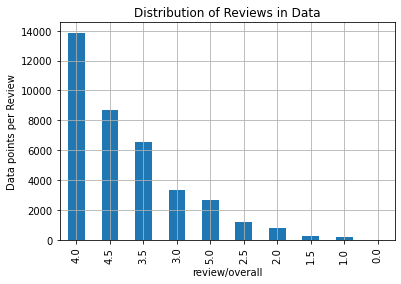

In [10]:
class_distribution = beer_data_null_sorted['review_overall'].value_counts()
print(class_distribution)
my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')
plt.xlabel('review/overall')
plt.ylabel('Data points per Review')
plt.title('Distribution of Reviews in Data')
plt.grid()
plt.show()

So we can see that we have more 4.0 rating 

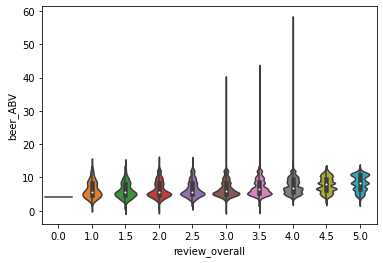

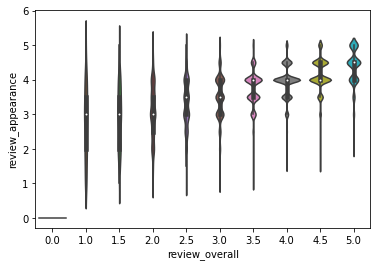

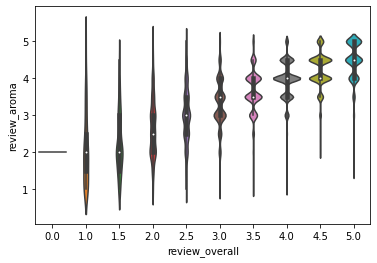

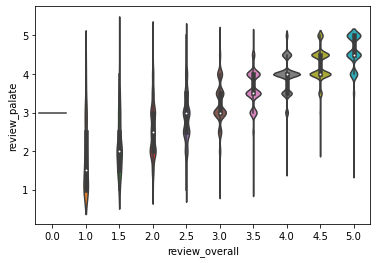

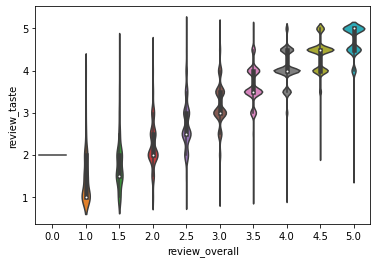

In [11]:
numerical_feature =  ['beer_ABV','review_appearance','review_aroma','review_palate','review_taste']

def outliers(column):
  sns.violinplot(x='review_overall',y=column, data=beer_data_null_sorted)
  plt.show()

for i in numerical_feature:
  outliers(i)

From this we get that for all numerical values all values are between 0 to 5 so no outliers are there and ABV value under 100%

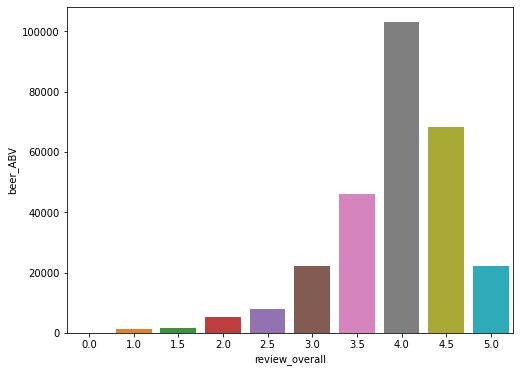

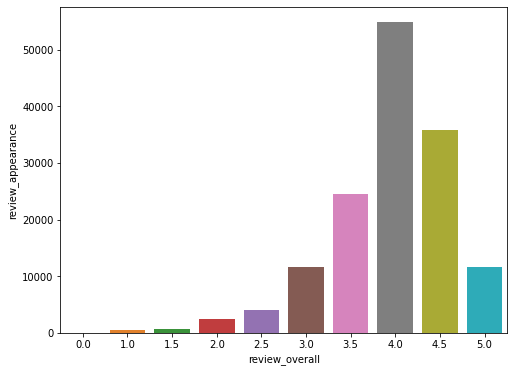

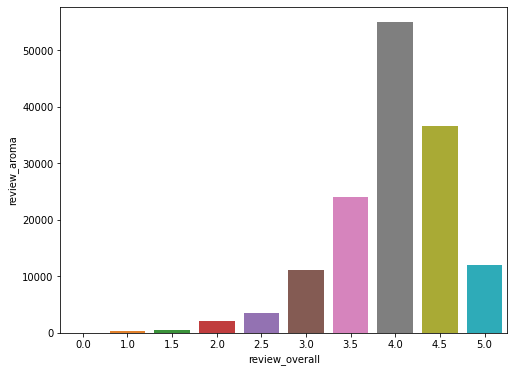

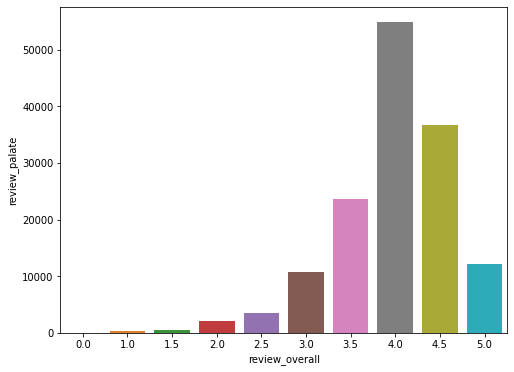

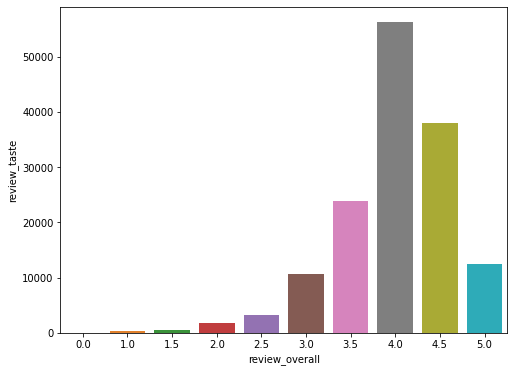

In [12]:
def bar_analysis(df,column2):
  
  avg_rating = pd.DataFrame(df.groupby("review_overall")[column2].apply(np.sum)).reset_index()
  avg_rating.columns = ['review_overall', column2]
  avg_rating.sort_values(by=[column2], inplace=True) 

  figure = plt.figure(figsize=(8,6)) 
  item_plot = sns.barplot(x="review_overall", y=column2, data=avg_rating)
  item_plot.set(xlabel="review_overall", ylabel = column2)

numerical_feature =  ['beer_ABV','review_appearance','review_aroma','review_palate','review_taste']

for i in numerical_feature:
  bar_analysis(beer_data_null_sorted,i)

So here we can see that from each graph that 4 rating is common for all type of rating becuase for each beer user like all the things

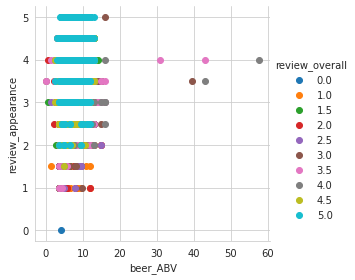

In [13]:
sns.set_style("whitegrid");
sns.FacetGrid(beer_data_null_sorted, hue="review_overall", size=4) \
   .map(plt.scatter, "beer_ABV", "review_appearance") \
   .add_legend();
plt.show();

Here we can see that for low ABV review high overall rating is there. Most of the beers are having low ABV which means low ABV is more required to user

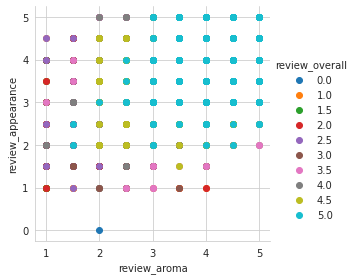

In [14]:
sns.set_style("whitegrid");
sns.FacetGrid(beer_data_null_sorted, hue="review_overall", size=4) \
   .map(plt.scatter, "review_aroma", "review_appearance") \
   .add_legend();
plt.show();

From this we can say that if review for aroma is high then appearence will also be high

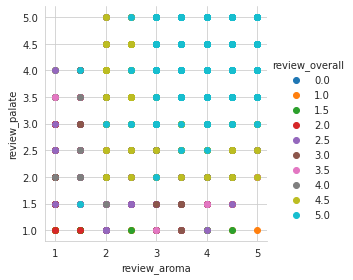

In [15]:
sns.set_style("whitegrid");
sns.FacetGrid(beer_data_null_sorted, hue="review_overall", size=4) \
   .map(plt.scatter, "review_aroma", "review_palate") \
   .add_legend();
plt.show();

so we are getting that if palate review is high then aroma will also be high or vice versa

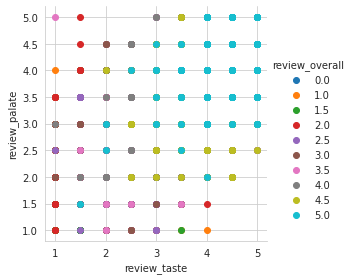

In [16]:
sns.set_style("whitegrid");
sns.FacetGrid(beer_data_null_sorted, hue="review_overall", size=4) \
   .map(plt.scatter, "review_taste", "review_palate") \
   .add_legend();
plt.show();

In this again we have observed that if beer has good rating for taste then it has good rating for palate. 

We obsereved positive relationship in each numerical feature lets confirm it by making correlation matrix

So we can also make an feature from this rating feartures as all of them having effect on overall rating

In [17]:
beer_data_null_sorted.corr()

,beer_ABV,beer_brewerId,review_appearance,review_aroma,review_overall,review_palate,review_taste,review_timeUnix
beer_ABV,1.000000,0.007455,0.288376,0.386340,0.197005,0.350656,0.354033,0.248846
beer_brewerId,0.007455,1.000000,-0.077973,-0.081571,-0.084932,-0.066468,-0.100513,0.206507
review_appearance,0.288376,-0.077973,1.000000,0.538076,0.498733,0.555833,0.531676,0.067531
review_aroma,0.386340,-0.081571,0.538076,1.000000,0.616117,0.608922,0.711809,0.109106
review_overall,0.197005,-0.084932,0.498733,0.616117,1.000000,0.697220,0.785220,0.065383
review_palate,0.350656,-0.066468,0.555833,0.608922,0.697220,1.000000,0.732092,0.094538
review_taste,0.354033,-0.100513,0.531676,0.711809,0.785220,0.732092,1.000000,0.092100
review_timeUnix,0.248846,0.206507,0.067531,0.109106,0.065383,0.094538,0.092100,1.000000


Now we can see that as we are getting in plots above we are having same result in this that with that all the review is positive effect on overall review and little positive effect by ABV value

In [18]:
beer_data_null_sorted['beer_name'].value_counts()

Founders Breakfast Stout                   1883
Founders KBS (Kentucky Breakfast Stout)    1441
Founders Centennial IPA                    1064
Founders Red's Rye PA                      1051
Founders Dirty Bastard                      983
                                           ... 
Bring Me A Shrubbery Ale                      1
Wheat Ale                                     1
Valhalla IPA                                  1
Breznak Bernstein                             1
Founders Bangin' Berry Cream                  1
Name: beer_name, Length: 1688, dtype: int64

In [19]:
beer_data_null_sorted['beer_style'].value_counts()

American Double / Imperial Stout    4495
American IPA                        3050
American Double / Imperial IPA      2872
Scotch Ale / Wee Heavy              2133
Russian Imperial Stout              2032
                                    ... 
Kristalweizen                          6
Lambic - Fruit                         6
Eisbock                                5
BiÃ¨re de Garde                        4
Flanders Red Ale                       2
Name: beer_style, Length: 95, dtype: int64

**Data Cleaing and Data Preparation**

In [20]:
def categorical_features(column):
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace(' ','_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace('(','_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace('/','_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace(')' ,'_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace('&' ,'_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace(',' ,'_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace(' ','_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.replace('-','_')
  beer_data_null_sorted[column] = beer_data_null_sorted[column].str.lower()
  beer_data_null_sorted[column].value_counts()

here we made a function for removing any space or any special characters

In [21]:
categorical_features('beer_name')
categorical_features('beer_style')


We use upper function to remove special characters from beer name and beer style

In [22]:
beer_data_null_sorted['beer_style'].value_counts()

american_double___imperial_stout    4495
american_ipa                        3050
american_double___imperial_ipa      2872
scotch_ale___wee_heavy              2133
russian_imperial_stout              2032
                                    ... 
kristalweizen                          6
berliner_weissbier                     6
eisbock                                5
biã¨re_de_garde                        4
flanders_red_ale                       2
Name: beer_style, Length: 95, dtype: int64

In [23]:
print("printing some random review text")
print(9, beer_data_null_sorted['review_text'].values[9])
print('-'*50)
print(34, beer_data_null_sorted['review_text'].values[34])
print('-'*50)
print(147, beer_data_null_sorted['review_text'].values[147])

printing some random review text
9 Brewed with five hop additions, this alleged IPA has a slight cidery aroma, zero carbonation, and not a shred of head or lace. It is simple, clear amber.			Unfortunately, Harmon really dropped the ball on this fall seasonal. It is green tasting and oddly devoid of even the slightest hop aroma. The 68 IBUs of Glacier hops really dont shine, making this hard to reconcile as a single hop showcase beer. One Hop Wonder is not a completely disastrous ale, but the body is lifeless and the beer remains conceptually undeveloped. Nothing in the taste or aroma remotely resemble an IPA. It tastes like tired yeasts unable to pull their weight, and the finish is deathly. 			Not up to Harmon standards.
--------------------------------------------------
34 A- Perfectly transparent dark rose body that pours with thin 1/2 finger foamy white head. Head almost instantaneously fades to a collar which holds the whole way down. Little to no lacing is left behind in the glas

In [24]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

We use regex to remove any phrase or special character

In [25]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [26]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

Now we use upper function to get clean text review fo the beer so that we can get better results

In [27]:
beer_data_null_sorted['review_text']=beer_data_null_sorted['review_text'].apply(str)

beer_data_null_sorted['preprocessed_reviews'] = preprocess_text(beer_data_null_sorted['review_text'].values)

100%|██████████| 37500/37500 [00:10<00:00, 3597.75it/s]


In [28]:
print("printing some random review text")
print(9, beer_data_null_sorted['preprocessed_reviews'].values[9])
print('-'*50)
print(34, beer_data_null_sorted['preprocessed_reviews'].values[34])
print('-'*50)
print(147, beer_data_null_sorted['preprocessed_reviews'].values[147])

printing some random review text
9 brewed five hop additions alleged ipa slight cidery aroma zero carbonation not shred head lace simple clear amber unfortunately harmon really dropped ball fall seasonal green tasting oddly devoid even slightest hop aroma 68 ibus glacier hops really dont shine making hard reconcile single hop showcase beer one hop wonder not completely disastrous ale body lifeless beer remains conceptually undeveloped nothing taste aroma remotely resemble ipa tastes like tired yeasts unable pull weight finish deathly not harmon standards
--------------------------------------------------
34 perfectly transparent dark rose body pours thin 1 2 finger foamy white head head almost instantaneously fades collar holds whole way little no lacing left behind glass nose overpowered rush tart raspberries sweet sugary raspberries present background dry raspberry upfront sweet bready malt backbone raspberry becomes quite tart finish subtle malt backbone disappears moment lingers ni

**Feature Engineering**

In [29]:
beer_data_null_sorted[ 'review_average' ] = round( ( ( beer_data_null_sorted[ 'review_aroma' ] + beer_data_null_sorted[ 'review_appearance' ] + beer_data_null_sorted[ 'review_palate' ] + beer_data_null_sorted[ 'review_taste' ] ) / 4 ) * 2 ) / 2

As discussed above we use average column to get review average

In [30]:
beer_new_features = (beer_data_null_sorted.groupby(['beer_name','beer_style'],as_index=False) 
                                          .agg({'review_aroma': 'mean', 'review_appearance':'mean', 
                                                'review_palate':'mean', 'review_taste':'mean'

                                            
                                                
                                                }) 
                                          .rename(columns={
                                                           'review_aroma': 'mean_review_aroma',
                                                          'review_appearance': 'mean_review_appearance',
                                                          'review_palate':'mean_review_palate',
                                                          'review_taste':'mean_review_taste'
                                                 
                                                          }))

beer_new_features

,beer_name,beer_style,mean_review_aroma,mean_review_appearance,mean_review_palate,mean_review_taste
0,"""the_wind_cried_mari...""_scottish_heather_ale",scottish_gruit___ancient_herbed_ale,4.175000,3.875000,3.925000,4.050000
1,'pooya_porter,american_porter,4.000000,3.000000,3.500000,4.000000
2,10_blocks_south,american_pale_ale__apa_,3.500000,3.500000,3.500000,4.000000
3,10_year_clelebration_ale,american_ipa,3.500000,4.000000,4.000000,4.500000
4,12_year_anniversary_ale,american_ipa,4.500000,4.000000,4.000000,4.000000
...,...,...,...,...,...,...
1692,zlatorog,czech_pilsener,3.000000,3.361111,3.277778,3.138889
1693,zorg,euro_strong_lager,3.000000,2.000000,1.500000,2.000000
1694,âaibo,euro_strong_lager,2.772727,2.939394,2.772727,2.621212
1695,ãgte_fynsk_boghvedebryg,belgian_pale_ale,2.500000,2.500000,2.500000,3.000000


In [31]:
beer_featured = pd.merge(beer_data_null_sorted, beer_new_features, on=['beer_name','beer_style'], how='outer')

We make mean of different review column with respect to beer name and beer style to get each beer and style rating 

In [32]:
beer_preprocessed  = beer_featured.drop(['review_text','user_profileName','review_timeUnix','review_timeStruct','beer_brewerId'],axis = 1)
beer_preprocessed

,beer_ABV,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,preprocessed_reviews,review_average,mean_review_aroma,mean_review_appearance,mean_review_palate,mean_review_taste
0,5.0,chiostro,herbed___spiced_beer,4.0,4.0,4.0,4.0,4.0,pours clouded gold thin white head nose quite ...,4.0,3.764706,3.852941,3.588235,3.470588
1,5.0,chiostro,herbed___spiced_beer,4.0,4.0,4.0,4.0,4.0,tap kickbacks pleasantly suprised not world cl...,4.0,3.764706,3.852941,3.588235,3.470588
2,5.0,chiostro,herbed___spiced_beer,4.0,3.0,4.0,3.5,3.5,tap beachwood bbq pours golden clear yellow lo...,3.5,3.764706,3.852941,3.588235,3.470588
3,5.0,chiostro,herbed___spiced_beer,4.0,4.5,4.0,4.0,4.0,ale absinthe leaves opaque golden color fruity...,4.0,3.764706,3.852941,3.588235,3.470588
4,5.0,chiostro,herbed___spiced_beer,4.5,4.0,4.5,3.0,3.0,not pleased website not working first became c...,3.5,3.764706,3.852941,3.588235,3.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,6.0,rinkuâkiai_agaro_tradicinis__agar_traditional_,euro_pale_lager,3.5,3.0,2.5,3.0,2.5,500 ml bottle lithuania pours golden swarms sm...,3.0,3.000000,3.500000,3.000000,2.500000
37496,5.0,pszeniczne,hefeweizen,3.5,3.0,3.5,3.0,3.0,poured bottle pale gold decent dense white hea...,3.0,3.000000,3.500000,3.000000,3.000000
37497,7.6,cauldron_brew,american_strong_ale,4.5,4.0,5.0,4.5,5.0,tap horse brass arrived time wife guinness fri...,4.5,4.000000,4.500000,4.500000,5.000000
37498,7.5,mojo_belgian_style_abbey_dubbel,dubbel,4.0,4.0,3.5,3.5,4.0,variant mother jones contains raisins molasses...,4.0,4.000000,4.000000,3.500000,4.000000


Now we will drop unnecessary column

In [33]:
beer_preprocessed['review_overall'] = beer_preprocessed['review_overall'].astype('str')

In [34]:
beer_preprocessed['review_overall']

0        4.0
1        4.0
2        4.0
3        4.0
4        4.5
        ... 
37495    2.5
37496    3.5
37497    5.0
37498    3.5
37499    4.0
Name: review_overall, Length: 37500, dtype: object

**Modelling**

In [35]:
# splitting test and train data
y = beer_preprocessed['review_overall'].values
X = beer_preprocessed.drop(['review_overall'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

In [36]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16833, 13)
(12375, 13)
(16833,)
(12375,)


**Feature Engineering for Text feature**

In [37]:

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_reviews'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review = vectorizer.transform(X_train['preprocessed_reviews'].values)
X_cv_reviews = vectorizer.transform(X_cv['preprocessed_reviews'].values)
X_test_reviews = vectorizer.transform(X_test['preprocessed_reviews'].values)


In [38]:
# Vectorizing teacher_prefix by using Count Vectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['beer_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_beer_name = vectorizer.transform(X_train['beer_name'].values)
X_cv_beer_name = vectorizer.transform(X_cv['beer_name'].values)
X_test_beer_name = vectorizer.transform(X_test['beer_name'].values)



In [39]:
# Vectorizing teacher_prefix by using Count Vectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['beer_style'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_beer_style = vectorizer.transform(X_train['beer_style'].values)
X_cv_beer_style = vectorizer.transform(X_cv['beer_style'].values)
X_test_beer_style = vectorizer.transform(X_test['beer_style'].values)



In [40]:
#Reshaping numerical data points to use in hstack to make test, train and cv dataset

X_train_beer_ABV = X_train['beer_ABV'].values.reshape(-1,1)
X_cv_beer_ABV = X_cv['beer_ABV'].values.reshape(-1,1)
X_test_beer_ABV = X_test['beer_ABV'].values.reshape(-1,1)


X_train_review_appearance = X_train['review_appearance'].values.reshape(-1,1)
X_cv_review_appearance = X_cv['review_appearance'].values.reshape(-1,1)
X_test_review_appearance = X_test['review_appearance'].values.reshape(-1,1)

X_train_review_aroma = X_train['review_aroma'].values.reshape(-1,1)
X_cv_review_aroma = X_cv['review_aroma'].values.reshape(-1,1)
X_test_review_aroma = X_test['review_aroma'].values.reshape(-1,1)


X_train_review_palate = X_train['review_palate'].values.reshape(-1,1)
X_cv_review_palate = X_cv['review_palate'].values.reshape(-1,1)
X_test_review_palate = X_test['review_palate'].values.reshape(-1,1)

X_train_review_taste = X_train['review_taste'].values.reshape(-1,1)
X_cv_review_taste = X_cv['review_taste'].values.reshape(-1,1)
X_test_review_taste = X_test['review_taste'].values.reshape(-1,1)


X_train_review_average = X_train['review_average'].values.reshape(-1,1)
X_cv_review_average = X_cv['review_average'].values.reshape(-1,1)
X_test_review_average = X_test['review_average'].values.reshape(-1,1)



X_train_mean_review_aroma = X_train['mean_review_aroma'].values.reshape(-1,1)
X_cv_mean_review_aroma = X_cv['mean_review_aroma'].values.reshape(-1,1)
X_test_mean_review_aroma = X_test['mean_review_aroma'].values.reshape(-1,1)


X_train_mean_review_appearance = X_train['mean_review_appearance'].values.reshape(-1,1)
X_cv_mean_review_appearance = X_cv['mean_review_appearance'].values.reshape(-1,1)
X_test_mean_review_appearance = X_test['mean_review_appearance'].values.reshape(-1,1)


X_train_mean_review_palate = X_train['mean_review_palate'].values.reshape(-1,1)
X_cv_mean_review_palate = X_cv['mean_review_palate'].values.reshape(-1,1)
X_test_mean_review_palate = X_test['mean_review_palate'].values.reshape(-1,1)



X_train_mean_review_taste = X_train['mean_review_taste'].values.reshape(-1,1)
X_cv_mean_review_taste = X_cv['mean_review_taste'].values.reshape(-1,1)
X_test_mean_review_taste = X_test['mean_review_taste'].values.reshape(-1,1)








In [41]:
X_train['beer_ABV'].shape

(16833,)

In [42]:
from scipy.sparse import hstack
X_tr = hstack((X_train_review, X_train_beer_name,X_train_beer_style,X_train_beer_ABV,X_train_review_appearance,X_train_review_aroma,X_train_review_palate,X_train_review_taste,X_train_review_average,X_train_mean_review_aroma,X_train_mean_review_appearance,X_train_mean_review_palate,X_train_mean_review_taste)).tocsr()
X_cr = hstack((X_cv_reviews, X_cv_beer_name,X_cv_beer_style,X_cv_beer_ABV,X_cv_review_appearance,X_cv_review_aroma,X_cv_review_palate,X_cv_review_taste,X_cv_review_average,X_cv_mean_review_aroma,X_cv_mean_review_appearance,X_cv_mean_review_palate,X_cv_mean_review_taste)).tocsr()
X_te = hstack((X_test_reviews, X_test_beer_name,X_test_beer_style,X_test_beer_ABV,X_test_review_appearance,X_test_review_aroma,X_test_review_palate,X_test_review_taste,X_test_review_average,X_test_mean_review_aroma,X_test_mean_review_appearance,X_test_mean_review_palate,X_test_mean_review_taste)).tocsr()
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)
print(X_tr[1][0][0][0])

Final Data matrix
(16833, 7033) (16833,)
(8292, 7033) (8292,)
(12375, 7033) (12375,)
  (0, 155)	0.09646961882309618
  (0, 181)	0.062247956722454874
  (0, 186)	0.1910000413549711
  (0, 191)	0.19564165897896
  (0, 217)	0.04652672536084869
  (0, 220)	0.18246281722419883
  (0, 255)	0.10683656516953531
  (0, 276)	0.13593482583809635
  (0, 399)	0.07828142662109065
  (0, 430)	0.06381172381407935
  (0, 497)	0.08348117665629678
  (0, 510)	0.029008647017114288
  (0, 538)	0.06562630424985758
  (0, 539)	0.13066931262276468
  (0, 540)	0.06356101227188575
  (0, 562)	0.04207284061801832
  (0, 571)	0.04682923772895355
  (0, 664)	0.06440574031580247
  (0, 693)	0.05614799769352518
  (0, 724)	0.08840170870777814
  (0, 826)	0.0966074680535775
  (0, 835)	0.07496895978865162
  (0, 836)	0.036411488445696194
  (0, 982)	0.05479244599939585
  (0, 1109)	0.13708964269778134
  :	:
  (0, 5067)	0.1469887557621359
  (0, 5083)	0.06663491446286297
  (0, 5151)	0.06501859414459413
  (0, 5166)	0.0682539609356796
  (0, 526

In [44]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)

    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [69]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    from sklearn.metrics import f1_score
    print('f1 score :', f1_score(y_test, pred_y, average='macro'))
    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    plot_confusion_matrix(test_y, pred_y)

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16833 entries, 22556 to 30953
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   beer_ABV                16833 non-null  float64
 1   beer_name               16833 non-null  object 
 2   beer_style              16833 non-null  object 
 3   review_appearance       16833 non-null  float64
 4   review_aroma            16833 non-null  float64
 5   review_palate           16833 non-null  float64
 6   review_taste            16833 non-null  float64
 7   preprocessed_reviews    16833 non-null  object 
 8   review_average          16833 non-null  float64
 9   mean_review_aroma       16833 non-null  float64
 10  mean_review_appearance  16833 non-null  float64
 11  mean_review_palate      16833 non-null  float64
 12  mean_review_taste       16833 non-null  float64
dtypes: float64(10), object(3)
memory usage: 1.8+ MB


**Multinomial Naive Bayes Model**

for alpha = 1e-05
for alpha = 0.0001
for alpha = 0.001
for alpha = 0.1
for alpha = 1
for alpha = 10
for alpha = 100
for alpha = 1000


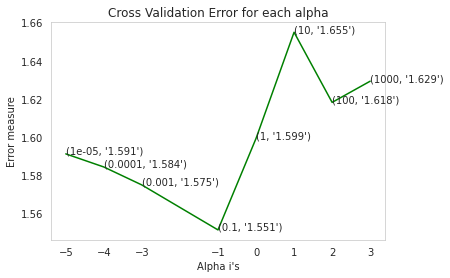

For values of best alpha =  0.1 The train log loss is: 1.3176703654688937
For values of best alpha =  0.1 The cross validation log loss is: 1.5510443036851258
For values of best alpha =  0.1 The test log loss is: 1.5314775255422468


In [75]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**Evaluation Metrics**

Log Loss : 1.5314775255422468
-------------------- Confusion matrix --------------------


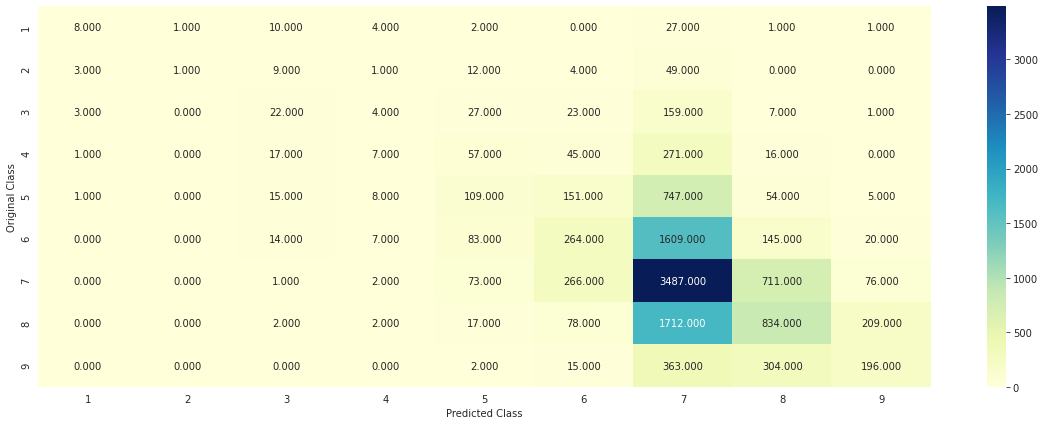

-------------------- Precision matrix (Columm Sum=1) --------------------


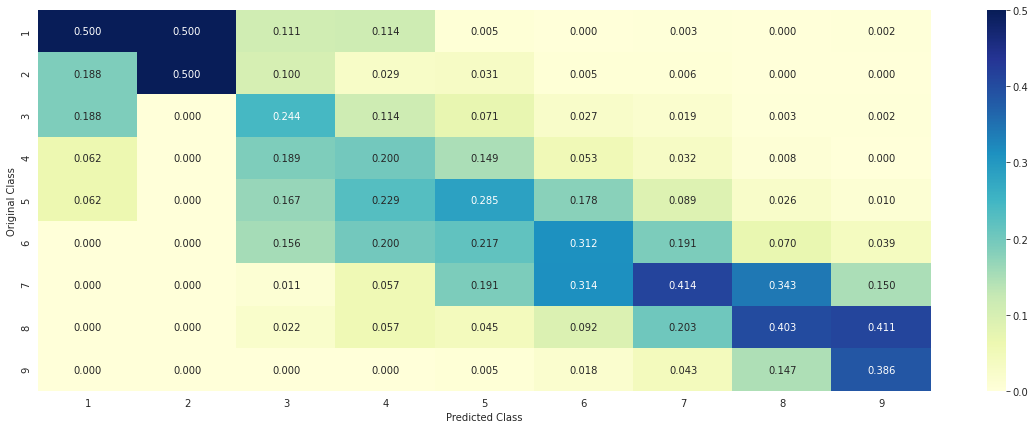

-------------------- Recall matrix (Row sum=1) --------------------


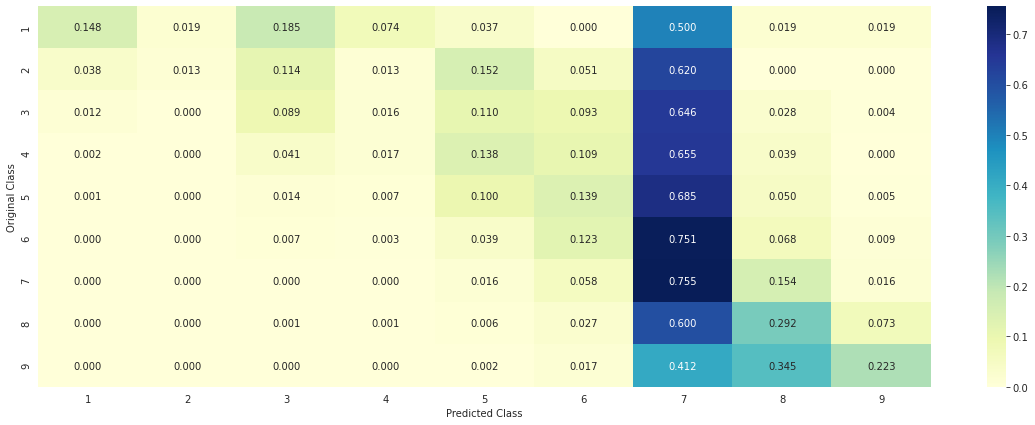

In [78]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)
sig_clf_probs = sig_clf.predict_proba(X_te)
print("Log Loss :",log_loss(y_test, sig_clf_probs))
plot_confusion_matrix(y_test, sig_clf.predict(X_te.toarray()))

*Observation* - So this model is best for multi class classification and also when text data is there then it is getting good accuracy because of laplace smoothing as points not present in train data will not effect test points

 **K-Nearest Neighnors Classifier**

for alpha = 5
for alpha = 11
for alpha = 15
for alpha = 21
for alpha = 31
for alpha = 41
for alpha = 51
for alpha = 99


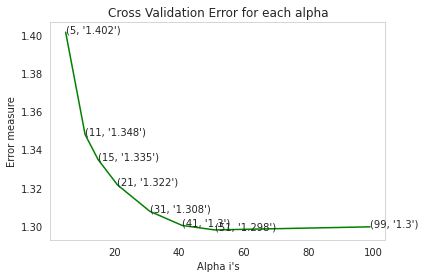

For values of best alpha =  51 The train log loss is: 1.2462891123834658
For values of best alpha =  51 The cross validation log loss is: 1.29794200074943
For values of best alpha =  51 The test log loss is: 1.2927887763019077


In [73]:
from sklearn.neighbors import KNeighborsClassifier

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**Evaluation Metrics**


f1 score : 0.32254488405064063
Log loss : 1.2927887763019077
-------------------- Confusion matrix --------------------


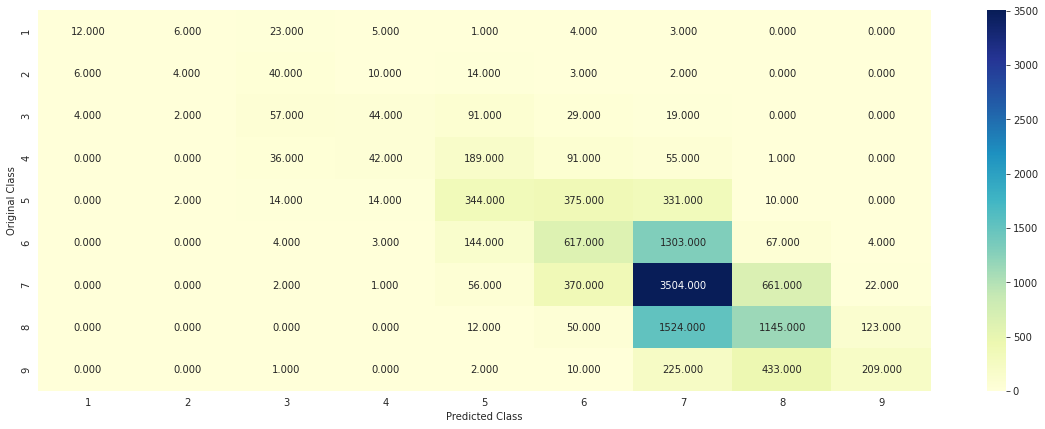

-------------------- Precision matrix (Columm Sum=1) --------------------


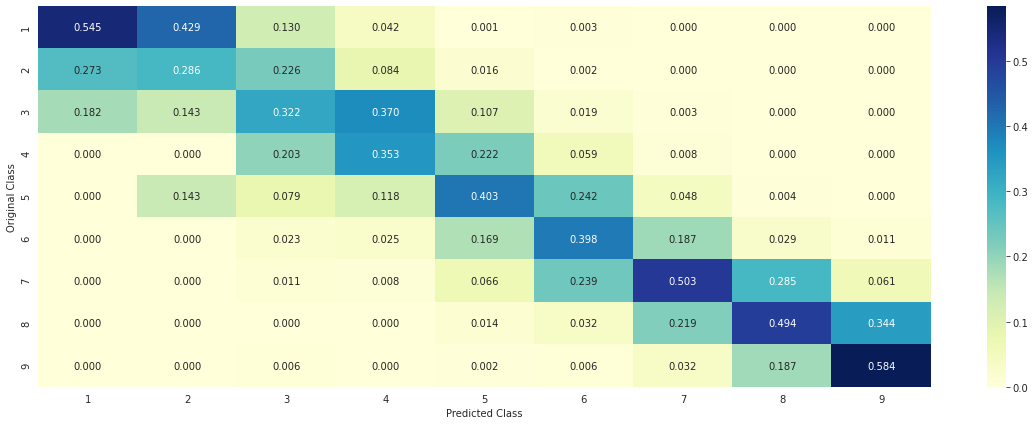

-------------------- Recall matrix (Row sum=1) --------------------


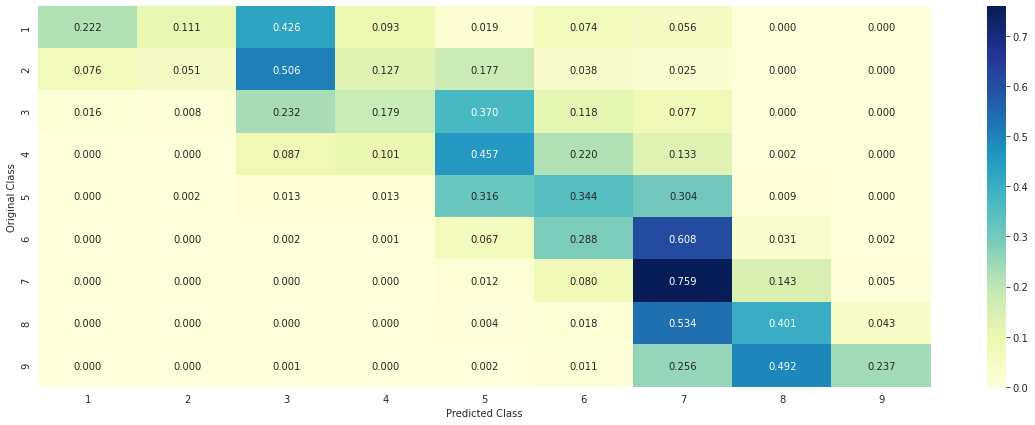

In [74]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_t, y_train, X_te, y_test, clf)

*Observation* - So this model has one hyperparameter and works well in multiclass classification but since it now works well in high dimension so it is giving good accuracy

**Support Vector Machine Model**

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100


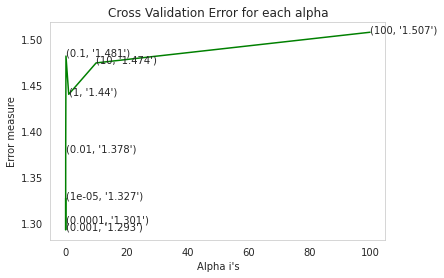

For values of best alpha =  0.001 The train log loss is: 1.1652288523696999
For values of best alpha =  0.001 The cross validation log loss is: 1.2932100250452319
For values of best alpha =  0.001 The test log loss is: 1.2940190505061677


In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#    clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**Evaluation Metrics**

f1 score : 0.22494604703248525
Log loss : 1.2940190505061677
-------------------- Confusion matrix --------------------


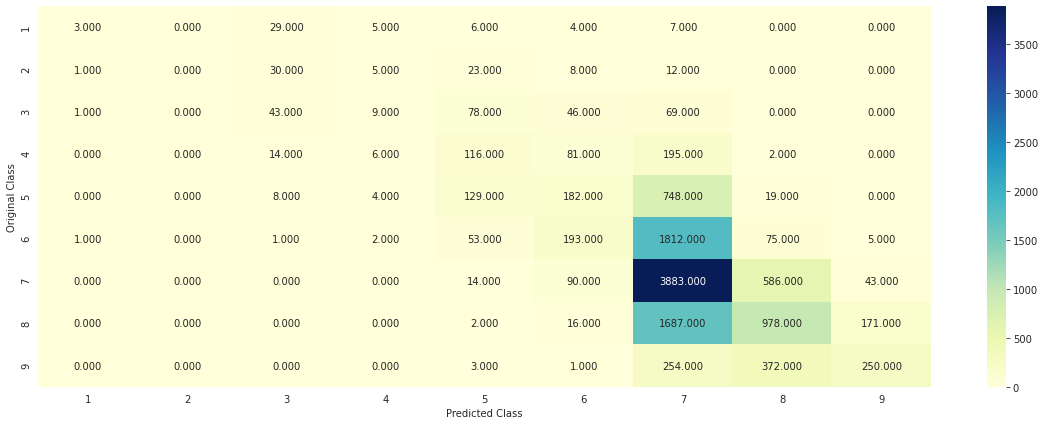

-------------------- Precision matrix (Columm Sum=1) --------------------


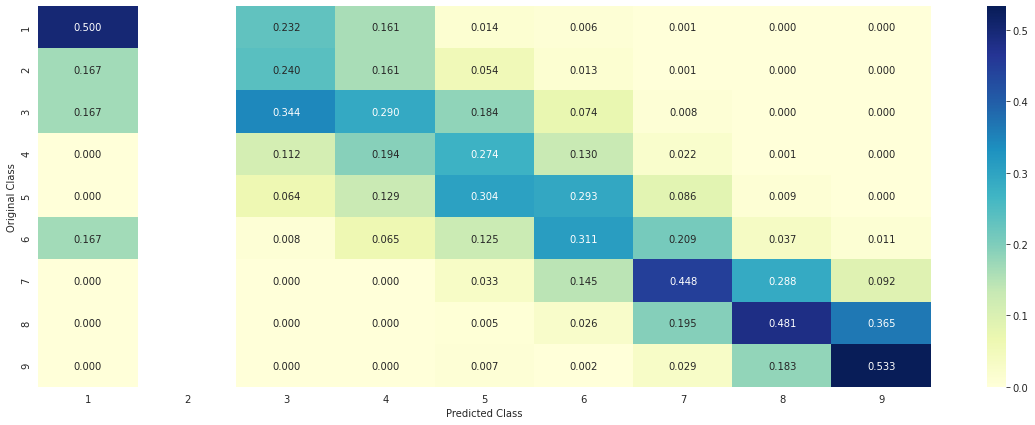

-------------------- Recall matrix (Row sum=1) --------------------


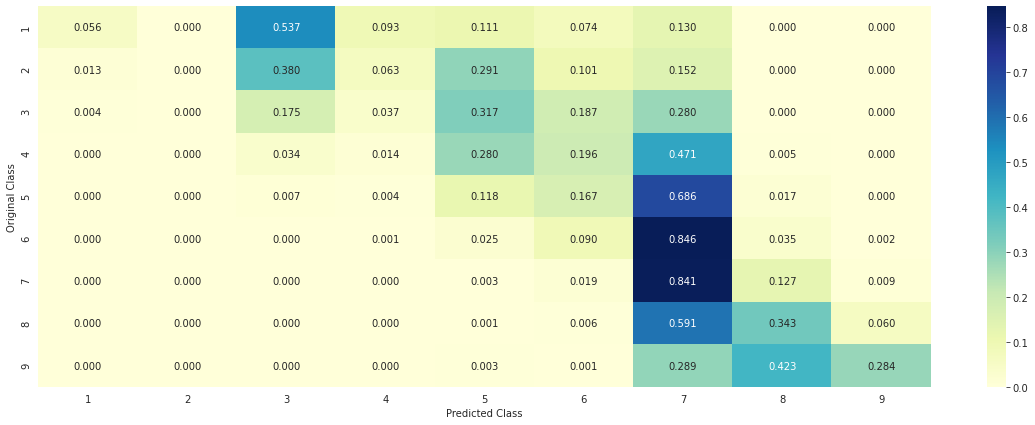

In [72]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_tr, y_train,X_te,y_test, clf)

*Observation* - So this model works well in higher dimension due to kernal trick. But this model takes time for large dataset. As this model not giving good accuracy due to inappropriate kernel

**Random Forest Classifier**

for n_estimators = 100 and max depth =  5
for n_estimators = 100 and max depth =  10
for n_estimators = 200 and max depth =  5
for n_estimators = 200 and max depth =  10
for n_estimators = 500 and max depth =  5
for n_estimators = 500 and max depth =  10
for n_estimators = 1000 and max depth =  5
for n_estimators = 1000 and max depth =  10
for n_estimators = 2000 and max depth =  5
for n_estimators = 2000 and max depth =  10


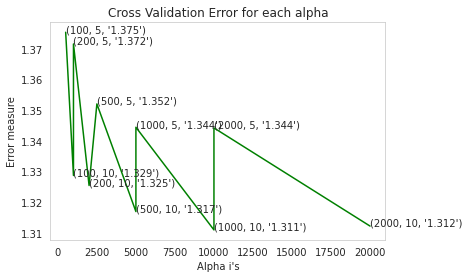

For values of best estimator =  1000 The train log loss is: 1.1038216223903894
For values of best estimator =  1000 The cross validation log loss is: 1.3109577714193192
For values of best estimator =  1000 The test log loss is: 1.2998222685830363


In [64]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_tr, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_tr, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cr)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**Evaluation Metrics**

f1 score : 0.2335558694185892
Log loss : 1.299822268583036
-------------------- Confusion matrix --------------------


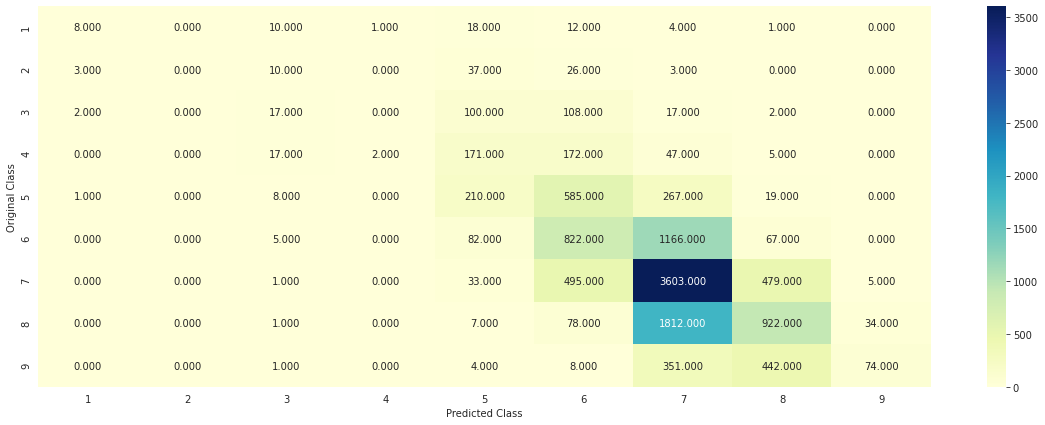

-------------------- Precision matrix (Columm Sum=1) --------------------


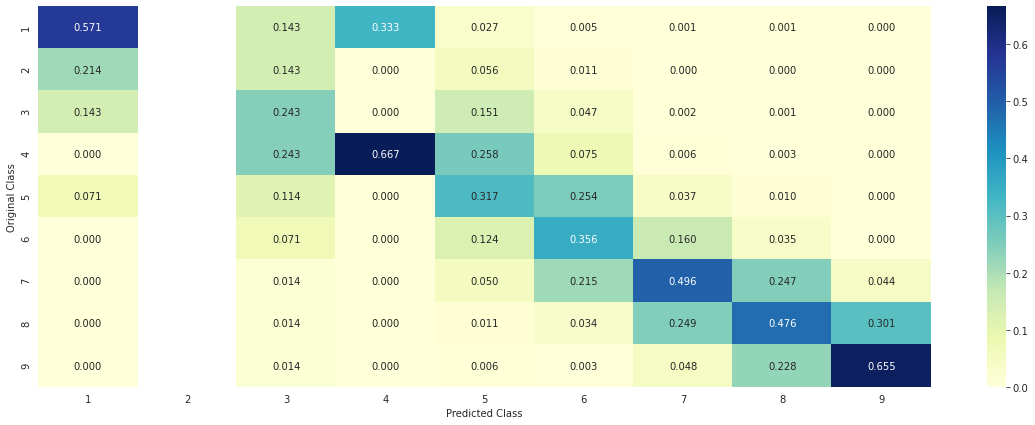

-------------------- Recall matrix (Row sum=1) --------------------


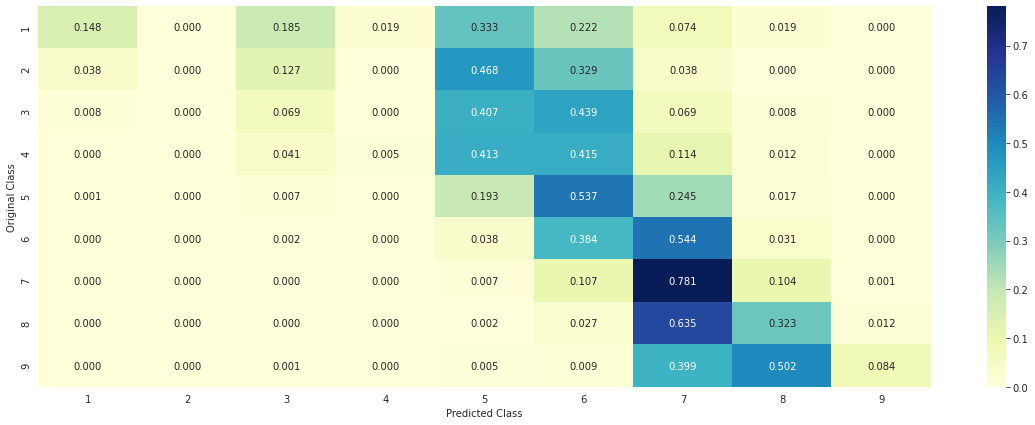

In [70]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_tr,y_train,X_te,y_test, clf)

*Observation* - So this model requires less feature engineering and also handles large dataset but due to its correlation of features it not gives better accuracy

So KNN is best model on the basis of lowest log loss, f1 score and confusion matrix